# Text Classification and Analysis
Now we're at the point where we should be able to:
* Read in a collection of documents - a *corpus* which contains the manually coded and predicted papers
* Do some preliminary data analysis and select only papers >= 2006
* Load the Spacy language model
* Do some text processing and lemmatize abstract using the Spcy lemmatizer
* Use TFIDF to fit and tranform the vectorized texts
* Implement NMF for topic modelling
* Implement t-SNE to visualize the topics
* Implement geoparsing

## Perform imports and load the dataset
The seen dataset contains the bibliometric information of over 1600 publications which have been manually labelled by two authors. Inconsistencies have been discussed and agreed upon. 

In [1]:
from typing import Tuple
import copy as cp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
pwd

'/Users/vmuccion/Documents/Projects/ClimateEducation/Notebooks'

In [4]:
### TODO Add your file path ###
file_path = '../Data/'
#File that was extracted from the big database having only labelled data. Relevant = 1 means relevant.
file_name = 'output_relevant_unseen_seen_merge_shuffle_.xlsx'
df = pd.read_excel(file_path + file_name)

df.head()

,Unnamed: 0,Abstract,Relevant,DOI,Title,Source title,PubYear,Authors,Times cited,Probability
0,9156,Abstract‘Effective interprofessional education...,0,10.1057/9781137363022_4,Leadership Development for Interprofessional T...,NaN,2014,"Lamb, Bryony; Clutton, Nick",2,100.00
1,6601,The Global Strategy for Plant Conservation (GS...,0,10.1007/s12225-011-9247-2,Using the Global Strategy for Plant Conservati...,Kew Bulletin,2010,"Clubbe, Colin; Hamilton, Martin; Corcoran, Mar...",11,100.00
2,1953,"Before human-caused CO2 emissions began, the n...",0,10.1007/978-3-030-52317-6_19,Aspects of a Legislative and Policy Framework ...,International Yearbook of Soil Law and Policy,2021,"Hannam, Ian",2,94.89
3,1602,The short-term effects of ambient temperature ...,0,10.1016/j.envpol.2021.118392,Long-term exposure to ambient temperature and ...,ENVIRONMENTAL POLLUTION,2022,"Hu, Jianxiong; Zhou, Maigeng; Qin, Mingfang; T...",0,100.00
4,9259,This study investigated pre-service science te...,1,10.1080/13504622.2011.630576,Moral reasoning patterns and influential facto...,Environmental Education Research,2012,"Tuncay, Büşra; Yılmaz-Tüzün, Özgül; Teksoz, Ga...",9,100.00


In [5]:
df.rename(columns={'Unnamed: 0': 'Identifier'}, inplace = True)

In [6]:
df['PubYear'] = df['PubYear'].astype(int)

### Take a look at a typical abstract.

In [7]:
from IPython.display import Markdown, display
display(Markdown('> '+df['Abstract'][250]))

> The Himalayan region has three major areas of interest, mountain environment, forest resources and fresh glacial water. Mountain people mostly follow agricultural livelihood system for their sustenance and economic wellbeing. However, contraction of resources and climate changes demand a shift from the conventional to improved management systems. The process of economic growth is reaching the unreached mountain societies, which are seen as a transition from total dependence to partial dependence on farming, through improved education, skill development and exploitation of potential niche areas for development. The unpredictable weather, fast depleting resources, inadequate infrastructure, low productivity of animals and heavy disasters witnessed during the recent past are some of the challenges to be met in the Himalayas. However, opportunities exist for resilience to these challenges through cultivation of high-value off-season vegetables, medicinal/aromatic plants/flowers and a path of reversing the shift from desirable to undesirable ecology. To enable the Himalayan people to promote sustainable farming, achieve sustainable livelihood and maintain mountain ecosystem services, these people need access to natural resources and empowerment of their women, which are supposed to be the key determinants for development and are required to be extended to them under specific legislations. Public investments in education, health, transport, research, extending credit, extension services, compensation for watershed management and conservation of biodiversity are some of the policy options suggested to achieve sustainable Himalayan development.

### Detect & remove empty strings
Technically, we're dealing with "whitespace only" strings. If the original .xlsx file had contained empty strings, pandas **.read_xlsx()** would have assigned NaN values to those cells by default.

In order to detect these strings we need to iterate over each row in the DataFrame. The **.itertuples()** pandas method is a good tool for this as it provides access to every field. For brevity we'll assign the names `i`, `lb` and `rv` to the `index`, `DOI` and `Title` columns, but actually we need to define over which columns we want to irerate and the code below needs to reflect this.

In [ ]:
#This is not needed here but we keep it for reference in case we need it at some point
#blanks = []  # start with an empty list

#for i,lb,rv in df.itertuples():  # iterate over the DataFrame
#    if type(rv)==str:            # avoid NaN values
#        if rv.isspace():         # test 'review' for whitespace
#            blanks.append(i)     # add matching index numbers to the list
        
#print(len(blanks), 'blanks: ', blanks)

Next we'll pass our list of index numbers to the **.drop()** method, and set `inplace=True` to make the change permanent.

In [ ]:
#df.drop(blanks, inplace=True)

#len(df)

## Take a quick look at the `label` column:

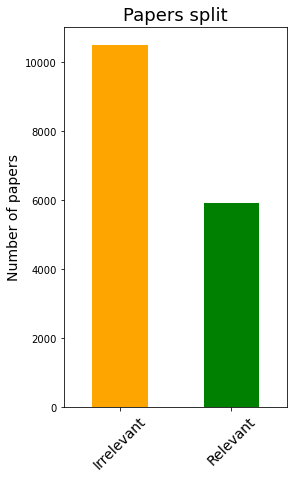

In [7]:
ax = df['Relevant'].value_counts().plot.bar(figsize = (4,7), color=['orange', 'green'])
ax.set_xticklabels(['Irrelevant','Relevant'], rotation = 45, fontsize=14)
ax.set_ylabel("Number of papers", fontsize=14)
ax.set_title('Papers split',fontsize=18)
plt.savefig('../Figure_GPT2/irrelevant_relevant_Split.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [6]:
df['Relevant'].value_counts()

0    10513
1     5917
Name: Relevant, dtype: int64

In [7]:
npr = df[df['Relevant'] == 1]

In [8]:
npr.reset_index(inplace = True)

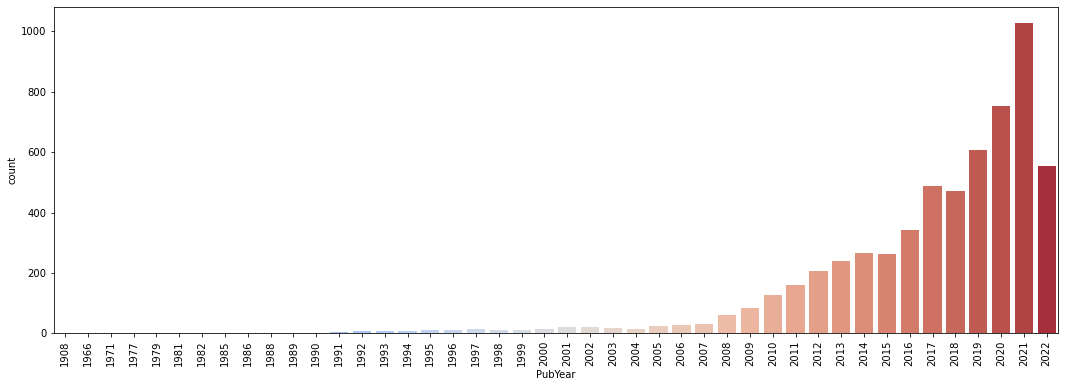

In [9]:
plt.figure(figsize=(18,6))
subgrade_order = sorted(npr['PubYear'].dropna().astype(int).unique())
x1 = npr['PubYear'].dropna().astype(int)
chart = sns.countplot(x=x1,data=npr,order = subgrade_order, palette = 'coolwarm')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

None
#npr['PubYear'].value_counts().plot(kind = 'bar', figsize = (12,6))

In [10]:
npr[npr['PubYear']<1960]

,index,Identifier,Abstract,Relevant,DOI,Title,Source title,PubYear,Authors,Times cited,Probability
140,323,2479,PROF. WARD explains in the preface to his book...,1,10.1038/079155a0,"Climate, considered especially in Relation to Man",Nature,1908,NaN,0,95.74


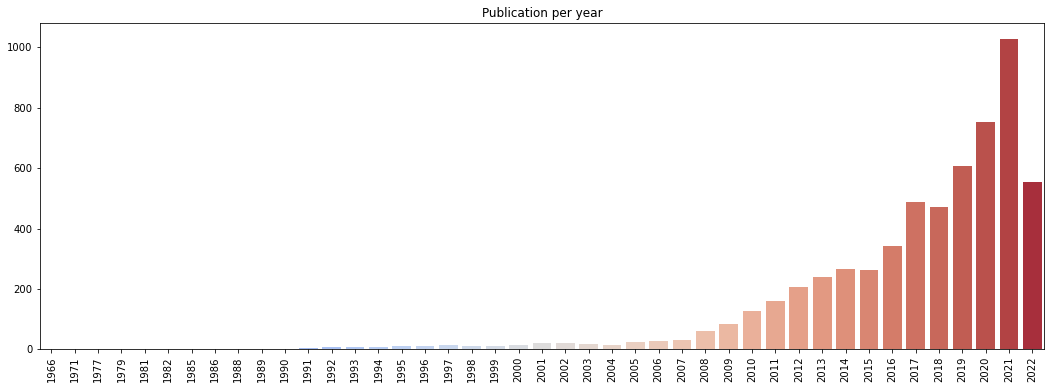

In [10]:
plt.figure(figsize=(18,6))
subgrade_order = sorted(npr[npr['PubYear']>1960]['PubYear'].dropna().astype(int).unique())
x1 = npr['PubYear'].dropna().astype(int)
chart = sns.countplot(x=x1,data=npr,order = subgrade_order, palette = 'coolwarm')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title("Publication per year")
chart.set_xlabel(xlabel = None)
chart.set_ylabel(ylabel = None)
plt.savefig('../Figure_GPT2/PubYear_All.png')
None

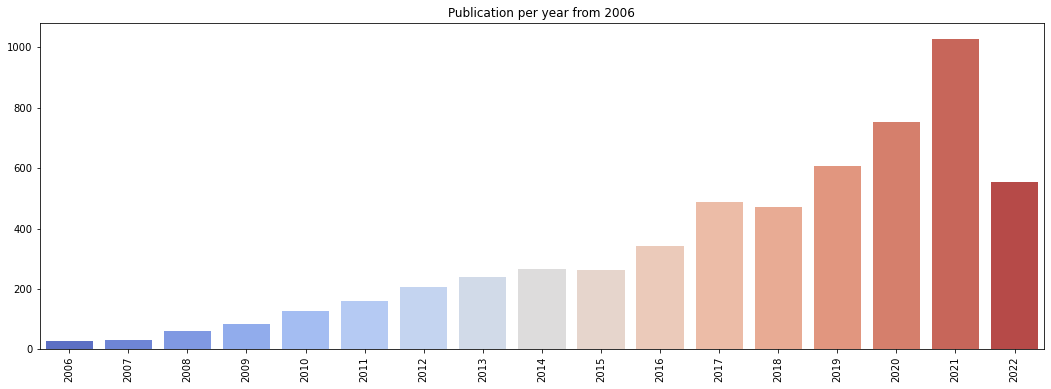

In [11]:
plt.figure(figsize=(18,6))
npr_2006 = npr[npr['PubYear'] >=2006]
subgrade_order = sorted(npr_2006['PubYear'].dropna().astype(int).unique())
x1 = npr_2006['PubYear'].dropna().astype(int)
chart = sns.countplot(x=x1,data=npr_2006,order = subgrade_order, palette = 'coolwarm')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set_title("Publication per year from 2006")
chart.set_xlabel(xlabel = None)
chart.set_ylabel(ylabel = None)
plt.savefig('../Figure_GPT2/PubYear_All_2006.png')
None

In [12]:
len(npr[npr['PubYear'] == 2001])

20

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
import spacy
nlp = spacy.load("en_core_web_lg")

2023-04-20 23:02:02.768739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_core_web_lg' (3.4.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [16]:
nlp.Defaults.stop_words |= {"climate","change","education", "climatic","changes","climat", "changing", "chang",
        "educ", "educational", "educative", "teach", "teaching","global", "warming", "die", 
                           "und", "das", "pro", "auf",'ll','ve'}

In [17]:
import requests
def britishize(string):
    url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
    american_to_british_dict = requests.get(url).json()    

    for american_spelling, british_spelling in american_to_british_dict.items():
        string = string.replace(american_spelling, british_spelling)
  
    return string

In [18]:
#Need a good network to run this because of the url request in the britishize function. 
npr_2006['Abstract_british'] = npr_2006['Abstract'].apply(lambda x: britishize(x))

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/1226290626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2006['Abstract_british'] = npr_2006['Abstract'].apply(lambda x: britishize(x))


In [19]:
#Use the spacy lemmatizer to get the best result so far
npr_2006['abstract_lemmatized'] = npr_2006['Abstract_british'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/1676249369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2006['abstract_lemmatized'] = npr_2006['Abstract_british'].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))


In [20]:
stop_words_2 = nlp.Defaults.stop_words

In [21]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_2)

In [22]:
dtm = tfidf.fit_transform(npr_2006['abstract_lemmatized'])

In [23]:
tfidf_weights = [(word, dtm.getcol(idx).sum()) for word, idx in tfidf.vocabulary_.items()]

In [24]:
feature_names = tfidf.get_feature_names_out()

In [25]:
from wordcloud import WordCloud
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=500).fit_words(dict(tfidf_weights))

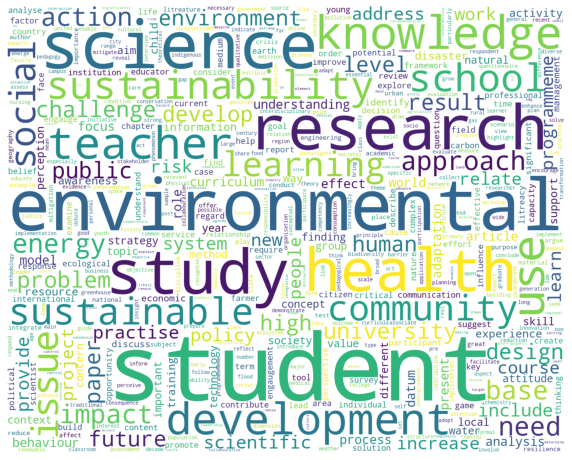

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('../Figure_GPT2_4/Climate_Education_500.png', dpi='figure',facecolor='auto', edgecolor='auto',pad_inches=0.1)

In [27]:
occ = np.asarray(dtm.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': tfidf.get_feature_names_out(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20)

,term,occurrences
10461,student,222.860210
4122,environmental,191.598115
9737,science,162.753275
9358,research,140.499049
10469,study,138.500165
5264,health,128.765262
6339,knowledge,126.384220
11496,use,126.256593
10758,teacher,117.370625
3302,development,117.214438


In [29]:
weights = np.asarray(dtm.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf.get_feature_names_out(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
10461,student,0.039064
4122,environmental,0.033584
9737,science,0.028528
9358,research,0.024627
10469,study,0.024277
5264,health,0.022571
6339,knowledge,0.022153
11496,use,0.022131
10758,teacher,0.020573
3302,development,0.020546


In [28]:
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
#add_stop = ['climate', 'change', 'education', 'science']
#stop_words = ENGLISH_STOP_WORDS.union(add_stop)
#nlp.Defaults.stop_words |= {"climate","change","education", "climatic","changes","climat", "changing", "chang",
#                           "educ", "educational", "educative", "teach", "teaching"}

stop_words = nlp.Defaults.stop_words

#nlp.Defaults.stop_words.add('climate','change','education')


# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [29]:
# Process the text
npr_2006['processed_text'] = npr_2006['abstract_lemmatized'].apply(process_text)
npr_2006.head()

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/552440705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2006['processed_text'] = npr_2006['abstract_lemmatized'].apply(process_text)


,index,Identifier,Abstract,Relevant,DOI,Title,Source title,PubYear,Authors,Times cited,Probability,Abstract_british,abstract_lemmatized,processed_text
0,4,9259,This study investigated pre-service science te...,1,10.1080/13504622.2011.630576,Moral reasoning patterns and influential facto...,Environmental Education Research,2012,"Tuncay, Büşra; Yılmaz-Tüzün, Özgül; Teksoz, Ga...",9,100.00,This study investigated pre-service science te...,this study investigate pre - service science t...,"[studi, investig, pre, servic, scienc, teacher..."
1,5,3646,This critical discourse analysis examined clim...,1,10.22323/2.18040202,Climate change skeptics teach climate literacy...,Journal of Science Communication,2019,"Colston, Nicole; Thomas, Julie",0,100.00,This critical discourse analysis examined clim...,this critical discourse analysis examine clima...,"[critic, discours, analysi, examin, denial, bo..."
2,7,12804,The consequences of climate change can involve...,1,10.3390/su12176985,Climate Change and Social Perception: A Case S...,Sustainability,2020,"Antronico, Loredana; Coscarelli, Roberto; De P...",3,97.60,The consequences of climate change can involve...,the consequence of climate change can involve ...,"[consequ, involv, ambit, veri, sever, reason, ..."
3,9,5308,"Purpose\n This study, from ...",1,10.1108/ijshe-09-2016-0179,Low factual understanding and high anxiety abo...,International Journal of Sustainability in Hig...,2017,"Pfautsch, Sebastian; Gray, Tonia",16,98.59,"Purpose\n This study, from ...","purpose \n this study , fr...","[purpos, studi, western, sydney, univers, aim,..."
4,10,12405,This paper explores different ethical principl...,1,10.1007/978-3-476-05832-4_11,Water Ethics,Reihe Interkulturelle Philosophie,2022,"Kelbessa, Workineh",0,99.31,This paper explores different ethical principl...,this paper explore different ethical principle...,"[paper, explor, differ, ethic, principl, play,..."


In [30]:
npr_2006.reset_index(inplace = True)

In [31]:
npr_2006.drop('level_0', inplace = True, axis = 1)

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/3247588195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2006.drop('level_0', inplace = True, axis = 1)


In [32]:
npr_2006.drop('index', inplace = True, axis = 1)

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/1532560573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_2006.drop('index', inplace = True, axis = 1)


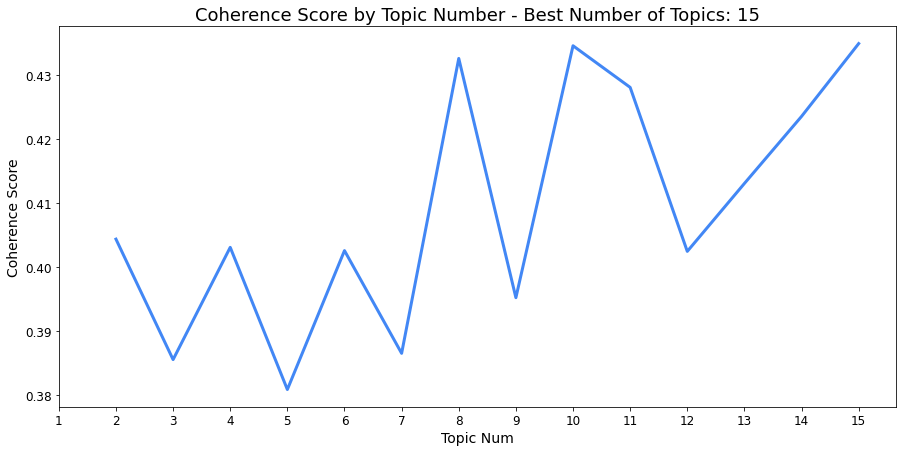

In [35]:
# Use Gensim's NMF to get the best num of topics via coherence score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter
texts = npr_2006['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
#topic_nums = list(np.arange(5, 75 + 1, 5))

topic_nums = list(np.arange(2, 16, 1))
# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(1, max(topic_nums) + 1, 1), fontsize=12)
plt.yticks(fontsize=12)

file_name = 'c_score'

fig.savefig(
    file_path + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [33]:
from sklearn.decomposition import NMF

In [34]:
nmf_model = NMF(n_components=10,random_state=43)

In [35]:
nmf_model.fit(dtm)

/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=10, random_state=43)

In [36]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['need', 'project', 'system', 'learning', 'new', 'challenge', 'approach', 'community', 'social', 'research']


THE TOP 20 WORDS FOR TOPIC #1
['human', 'healthcare', 'planetary', 'care', 'nurse', 'professional', 'public', 'nursing', 'medical', 'health']


THE TOP 20 WORDS FOR TOPIC #2
['knowledge', 'result', 'design', 'learn', 'learning', 'use', 'study', 'course', 'school', 'student']


THE TOP 20 WORDS FOR TOPIC #3


/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['impact', 'factor', 'risk', 'level', 'information', 'study', 'knowledge', 'perception', 'adaptation', 'farmer']


THE TOP 20 WORDS FOR TOPIC #4
['institution', 'goal', 'paper', 'sdg', 'business', 'esd', 'university', 'development', 'sustainable', 'sustainability']


THE TOP 20 WORDS FOR TOPIC #5
['concern', 'awareness', 'problem', 'human', 'attitude', 'issue', 'child', 'environment', 'behaviour', 'environmental']


THE TOP 20 WORDS FOR TOPIC #6
['efficiency', 'consumption', 'solar', 'fossil', 'carbon', 'fuel', 'emission', 'technology', 'renewable', 'energy']


THE TOP 20 WORDS FOR TOPIC #7
['geomorphology', 'encyclopaedic', 'alphabetical', 'biogeography', 'discipline', 'cover', 'entry', 'dictionary', 'physical', 'geography']


THE TOP 20 WORDS FOR TOPIC #8
['classroom', 'litreacy', 'pre', 'study', 'topic', 'school', 'service', 'scientific', 'teacher', 'science']


THE TOP 20 WORDS FOR TOPIC #9
['preparedness', 'natural', 'resilience', 'hazard', 'flood', 'child', 'community', 'reductio

In [37]:
topics = ['Social_Research',
          'Medical_Health',
          'School_Student',
          'Adaptation_Agriculture',
          'Sustainability_Sustainable',
          'Environment_Behaviour',
          'Energy_Mitigation',
          'Physical_Geography',
          'Teacher_Science',
          'Disaster_Risk'
          ]

In [38]:
nc = len(nmf_model.components_)

In [39]:
topic_df3 = pd.DataFrame(
    nmf_model.transform(dtm), 
    columns=["topic_{}".format(i) for i in range(nc)]
).astype(float)
topic_df3.index = npr_2006.index
npr_2006 = pd.concat([npr_2006, topic_df3], axis=1)

In [40]:
topic_results = nmf_model.transform(dtm)

In [41]:
from sklearn.manifold import TSNE

tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=50, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(topic_results)

/Users/vmuccion/anaconda3/envs/ClimateEducation2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5705 samples in 0.003s...
[t-SNE] Computed neighbors for 5705 samples in 0.731s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5705
[t-SNE] Computed conditional probabilities for sample 2000 / 5705
[t-SNE] Computed conditional probabilities for sample 3000 / 5705
[t-SNE] Computed conditional probabilities for sample 4000 / 5705
[t-SNE] Computed conditional probabilities for sample 5000 / 5705
[t-SNE] Computed conditional probabilities for sample 5705 / 5705
[t-SNE] Mean sigma: 0.013793
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.139297
[t-SNE] KL divergence after 2000 iterations: 1.317181


In [42]:
tsne_lsa_vectors = pd.DataFrame(tsne_lsa_vectors,columns=['x','y'])
tsne_lsa_vectors['hue'] = topic_results.argmax(axis=1)

In [43]:
tsne_lsa_vectors['hue'].value_counts()

0    1153
3     818
2     739
8     666
4     664
5     652
1     350
9     297
6     276
7      90
Name: hue, dtype: int64

In [47]:
### A bit of a hacking: run this one first, get possibly an error, then run the one below which will give 
#no accurate legend then run this cell again and then again the one below. It should do the trick...
import matplotlib.patches as mpatches
legend_list = []
colors = []
for i in range(len(topics)):
    idx = np.where(data['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/1488598304.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



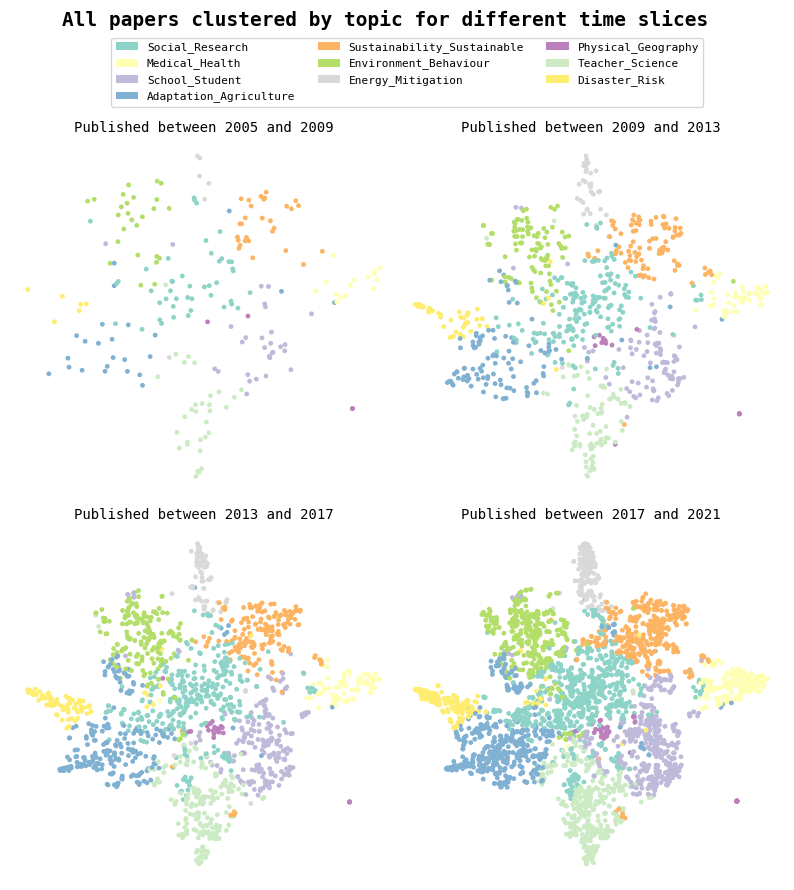

In [157]:
plt.rc('font',family='monospace')
#plt.style.use('ggplot')

fig, axs = plt.subplots(2,2, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()
count = 0
legend = []
for year, idx in zip([2009,2013,2017,2021], range(4)):
    data = tsne_lsa_vectors[(npr['PubYear']<=year) & (npr['PubYear']>year-5)]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set3")
    #axs[idx].set_title('published between {} and {}'.format(year),**{'fontsize':'10'})
    axs[idx].set_title(f"Published between {year-4} and {year}",**{'fontsize':'10'})
    axs[idx].axis('off')

plt.suptitle("All papers clustered by topic for different time slices",**{'fontsize':'14','weight':'bold'})
#plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')

fig.legend(legend_list,topics,loc=(0.14,0.88),ncol = 3, fontsize = 8)
plt.subplots_adjust(top=0.85)
plt.savefig('../Figure_GPT2_4/Climate_Education_tse_time.png',bbox_inches='tight', dpi = 400)

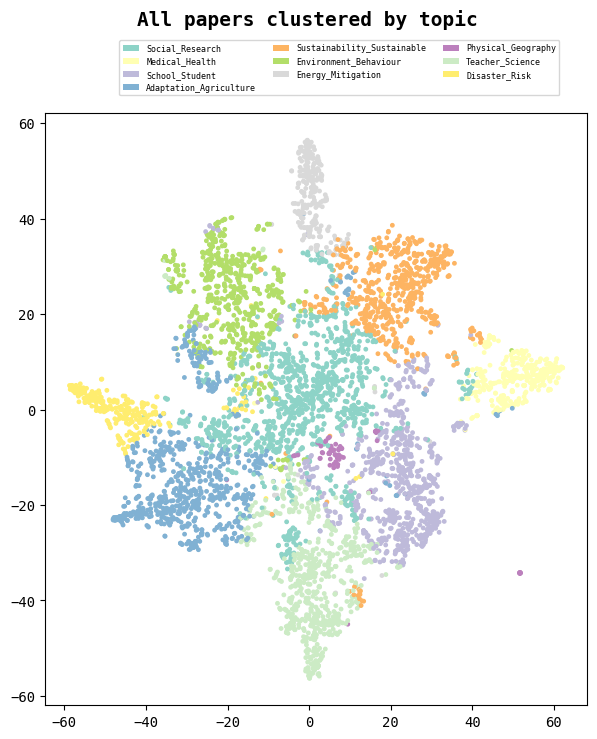

In [143]:
fig, axs = plt.subplots(1,1, figsize=(7, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
data = tsne_lsa_vectors
scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set3")
fig.legend(legend_list,topics,loc=(0.2,0.87),ncol=3, fontsize = 6)
plt.suptitle("All papers clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.subplots_adjust(top=0.85)
#plt.axis('off')
#plt.show()
plt.savefig('../Figure_GPT2_4/Climate_Education_tse.png')

In [52]:
npr_2006['Topic'] = topic_results.argmax(axis=1)

In [53]:
my_topic_dic = {0: 'Social_Research', 1:'Health_Medical', 2: 'School_Student', 
                3: 'Adaptation_Agriculture', 4: 'Sustainability_Sustainable', 
                5: 'Environment_Behaviour', 6: 'Energy_Mitigation', 
                7: 'Physical_Geography', 8:'Teacher_Science', 9:'Disaster_Risk'}

In [54]:
npr_2006['Topic Label'] = npr_2006['Topic'].map(my_topic_dic)

<AxesSubplot:>

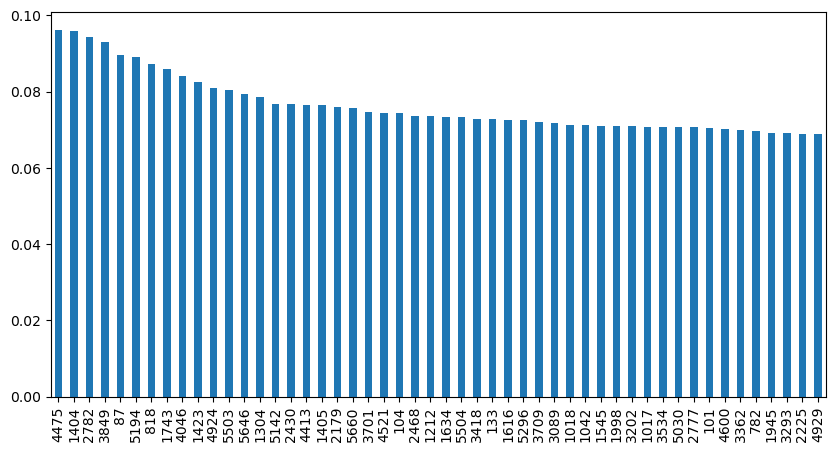

In [55]:
plt.style.use('default')
npr_2006['topic_0'].sort_values(ascending = False).head(50).plot.bar(figsize = (10,5))

In [151]:
npr_2006.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5705 entries, 0 to 5704
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Identifier           5705 non-null   int64  
 1   Abstract             5705 non-null   object 
 2   Relevant             5705 non-null   int64  
 3   DOI                  5705 non-null   object 
 4   Title                5705 non-null   object 
 5   Source title         5267 non-null   object 
 6   PubYear              5705 non-null   int64  
 7   Authors              5637 non-null   object 
 8   Times cited          5705 non-null   int64  
 9   Probability          5705 non-null   float64
 10  Abstract_british     5705 non-null   object 
 11  abstract_lemmatized  5705 non-null   object 
 12  processed_text       5705 non-null   object 
 13  topic_0              5705 non-null   float64
 14  topic_1              5705 non-null   float64
 15  topic_2              5705 non-null   f

In [56]:
npr_2006["Topic Label"].nunique()

10

In [57]:
npr_2006["Topic Label"].value_counts(normalize=True)*100

Social_Research               20.210342
Adaptation_Agriculture        14.338300
School_Student                12.953550
Teacher_Science               11.673970
Sustainability_Sustainable    11.638913
Environment_Behaviour         11.428571
Health_Medical                 6.134969
Disaster_Risk                  5.205960
Energy_Mitigation              4.837862
Physical_Geography             1.577564
Name: Topic Label, dtype: float64

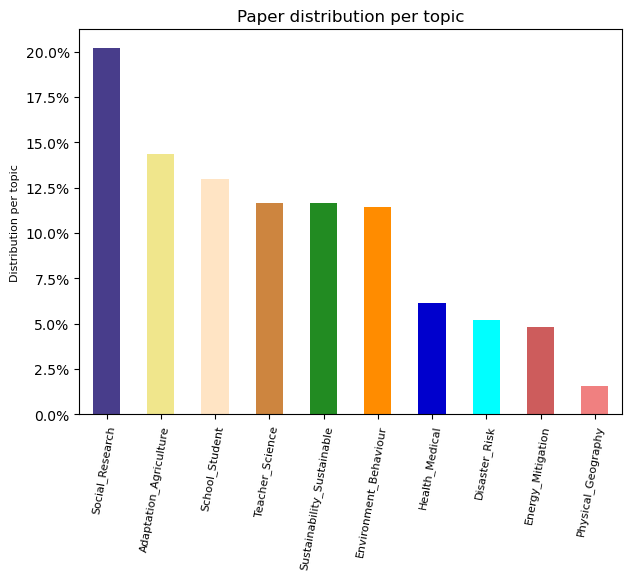

In [58]:
import matplotlib.colors as pltc
import matplotlib.ticker as mtick
all_colors = [k for k,v in pltc.cnames.items()]
from random import sample
import random
random.seed(22)
colors = sample(all_colors,npr_2006["Topic Label"].nunique())
ax = (npr_2006["Topic Label"].value_counts(normalize=True)*100).plot.bar(figsize = (7,5),color= colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, fontsize=8, ha='right', rotation_mode="anchor")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel("Distribution per topic", fontsize=8)
ax.set_title("Paper distribution per topic", fontsize=12)
plt.savefig('../Figure_GPT2_4/Paper_topic.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


[Text(1, 0, 'topic_0'),
 Text(2, 0, 'topic_1'),
 Text(3, 0, 'topic_2'),
 Text(4, 0, 'topic_3'),
 Text(5, 0, 'topic_4'),
 Text(6, 0, 'topic_5'),
 Text(7, 0, 'topic_6'),
 Text(8, 0, 'topic_7'),
 Text(9, 0, 'topic_8'),
 Text(10, 0, 'topic_9')]

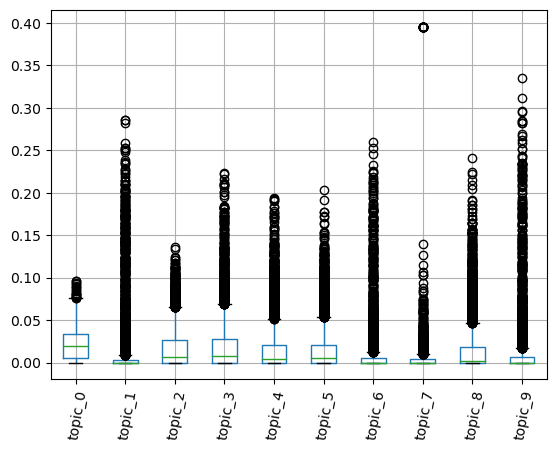

In [59]:
ax = npr_2006.boxplot(column = ['topic_0', 'topic_1', 'topic_2', 'topic_3','topic_4', 'topic_5', 'topic_6', 
                           'topic_7','topic_8','topic_9'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, fontsize=10, ha='right', rotation_mode="anchor")

In [60]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x, y, hue = None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [61]:
npr_topic = npr_2006[['topic_0','topic_1','topic_2','topic_3','topic_4', 'topic_5', 
                      'topic_6', 'topic_7','topic_8','topic_9']]

npr_topic.rename(columns={'topic_0': 'Social_Research', 'topic_1': 'Health_Medical',
                          'topic_2': 'School_Student',
                          'topic_3': 'Adaptation_Agriculture',
                          'topic_4': 'Sustainability_Sustainable',
                          'topic_5': 'Environment_Behaviour', 
                          'topic_6': 'Energy_Mitigation',
                          'topic_7': 'Physical_Geography',
                          'topic_8': 'Teacher_Science',
                          'topic_9': 'Disaster_Risk'                         
                         }, inplace = True)


/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/1085829019.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  npr_topic.rename(columns={'topic_0': 'Social_Research', 'topic_1': 'Health_Medical',


[Text(1, 0, 'Social_Research'),
 Text(2, 0, 'Health_Medical'),
 Text(3, 0, 'School_Student'),
 Text(4, 0, 'Adaptation_Agriculture'),
 Text(5, 0, 'Sustainability_Sustainable'),
 Text(6, 0, 'Environment_Behaviour'),
 Text(7, 0, 'Energy_Mitigation'),
 Text(8, 0, 'Physical_Geography'),
 Text(9, 0, 'Teacher_Science'),
 Text(10, 0, 'Disaster_Risk')]

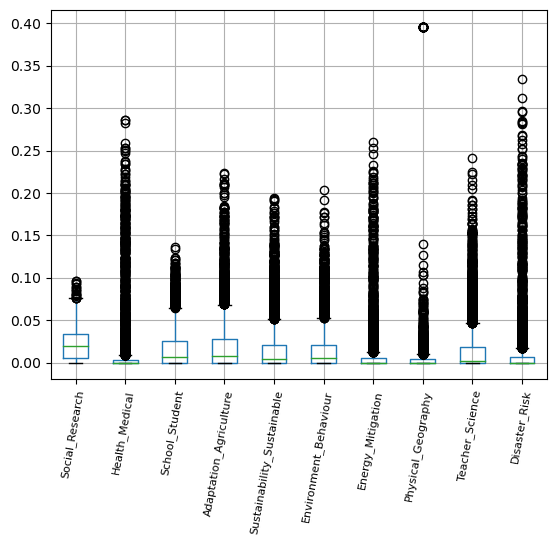

In [62]:
ax = npr_topic.boxplot()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, fontsize=8, ha='right', rotation_mode="anchor")

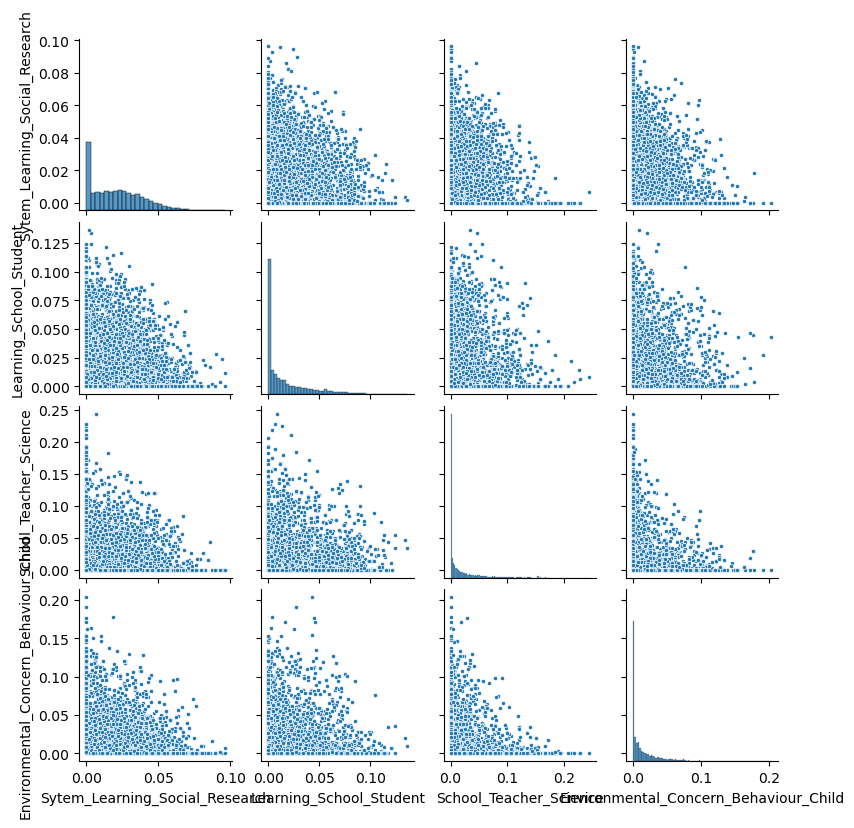

In [159]:
plt.style.use('default')

g = sns.pairplot(
    npr_topic,
    x_vars=["Sytem_Learning_Social_Research", "Learning_School_Student", "School_Teacher_Science","Environmental_Concern_Behaviour_Child"],
    y_vars=["Sytem_Learning_Social_Research", "Learning_School_Student", "School_Teacher_Science","Environmental_Concern_Behaviour_Child"],
height=2, markers=".", diag_kind = 'hist')

#g.map_lower(corrfunc)
#plt.show()
plt.savefig('../Figure_GPT2_2/Climate_Education_pairplot.png')

Something to try will be to make a heatmap with two topic and cross check when both of them exceed a certain threshold, e.g topic university and topic children...

In [64]:
aa1=npr_topic.corr()

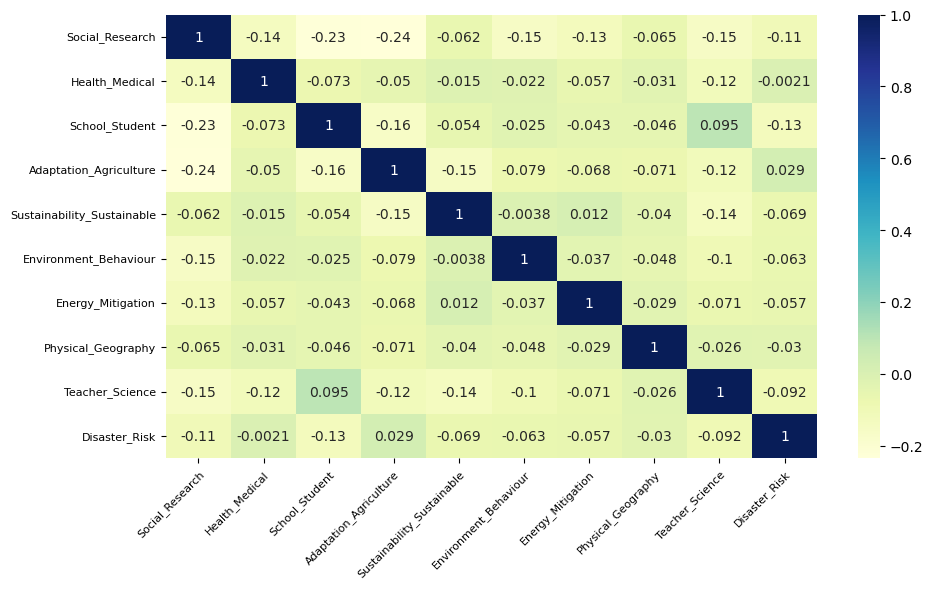

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(aa1, ax=ax, annot=True, cmap='YlGnBu',)
ax.set_xticklabels(labels =ax.get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")
ax.tick_params(axis='both', labelsize=8)
plt.tight_layout()
plt.savefig('../Figure_GPT2_4/Heatmap_topics_all.png')

In [66]:
aa= npr_topic[["Social_Research","School_Student", "Teacher_Science",
                "Environment_Behaviour"]].corr()

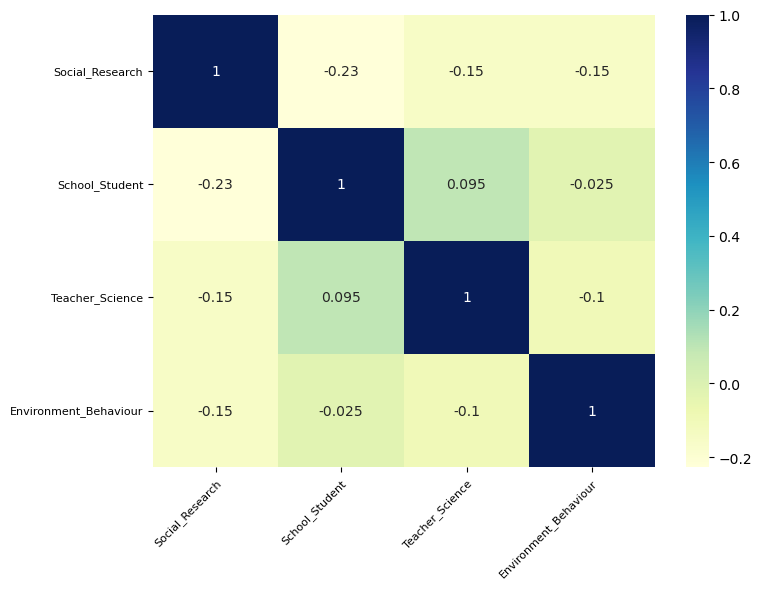

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(aa, ax=ax, annot=True, cmap='YlGnBu',)
ax.set_xticklabels(labels =ax.get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")
ax.tick_params(axis='both', labelsize=8)
plt.tight_layout()
plt.savefig('../Figure_GPT2_4/Heatmap_topics_selected.png')

In [68]:
npr_2006['Source title']=npr_2006['Source title'].str.lower().replace('proceedings of the national academy of sciences of the united states of america','pnas')

In [69]:
npr_2006['Source title'] = npr_2006['Source title'].str.lower().replace('international journal of sustainability in higher education','Int Jour Sust Higher Edu')

In [70]:
a = npr_2006.groupby(by=npr_2006['Source title'].str.lower())['Times cited'].sum()

b= a/(a.sum())

In [71]:
a.sum()

58207

In [72]:
c = (b*100).sort_values(ascending=False)

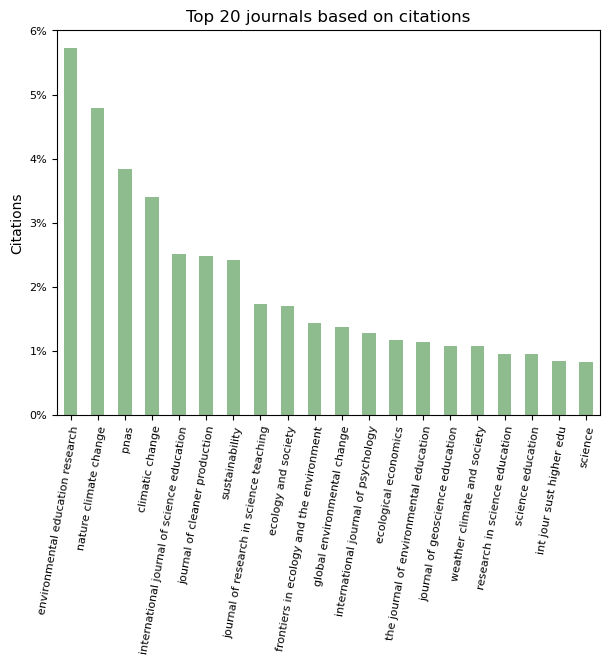

In [73]:
title='Journal citations'
#ylabel='Times cited'
#ax = npr_2006.groupby(by=npr_2006['Source title'].str.lower())['Times cited'].sum().sort_values(ascending = False).head(20).plot.barh(figsize = (10,12),color = 'darkseagreen')
ax = c.head(20).plot.bar(figsize = (7,5),color = 'darkseagreen')
ax.set(xlabel=None)
ax.set(ylabel='Citations')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, fontsize=8, ha='right', rotation_mode="anchor")
ax.tick_params(axis='both', labelsize=8)
#ax.set_ylim(10000, 90000)
#ax.set_ylim(10000, 900000)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_title(label = 'Top 20 journals based on citations')
plt.savefig('../Figure_GPT2_4/Journals_citations.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [74]:
npr_2006['Source title'].str.lower().value_counts(normalize = True).head(20)

sustainability                                                        0.041200
environmental education research                                      0.029998
climate change management                                             0.021644
journal of geoscience education                                       0.010822
world sustainability series                                           0.010822
int jour sust higher edu                                              0.009683
international journal of science education                            0.009303
journal of cleaner production                                         0.009303
climatic change                                                       0.009113
weather climate and society                                           0.007594
cultural studies of science education                                 0.006835
international research in geographical and environmental education    0.006835
journal of environmental studies and sciences       

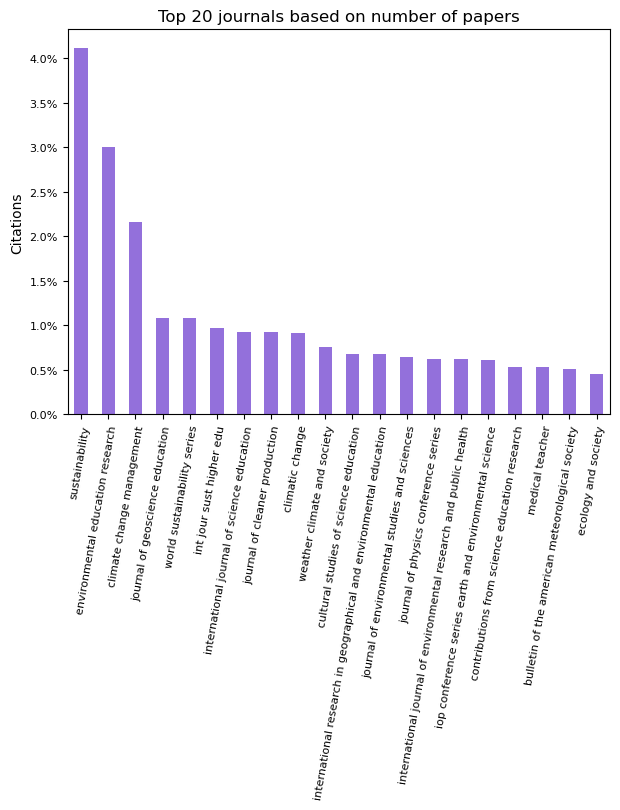

In [75]:
title='Number of publications'
#ylabel='Times cited'
ax = (npr_2006['Source title'].str.lower().value_counts(normalize = True)*100).head(20).plot.bar(figsize = (7,5),color ="mediumpurple")
ax.set(xlabel=None)
ax.set(ylabel='Publications')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, fontsize=8, ha='right', rotation_mode="anchor")
ax.tick_params(axis='both', labelsize=8)
#ax.set_ylim(10000, 90000)
#ax.set_ylim(10000, 900000)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
ax.set_title(label = 'Top 20 journals based on number of papers')
ax.tick_params(axis='both', labelsize=8)
plt.savefig('../Figure_GPT2_4/Journals_number.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

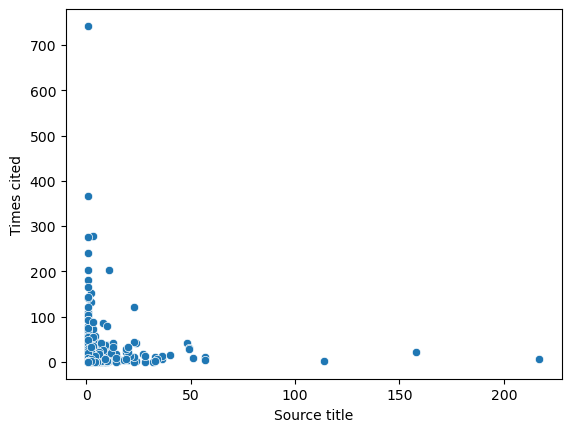

The correlation between average times cited and number of publications in a given journal is 0.03808682450423315


In [70]:
x1 = npr_2006['Source title'].value_counts()
y1 = npr_2006.groupby('Source title')['Times cited'].mean()
sns.scatterplot(data = npr_2006, x=x1, y = y1)
#plt.xlim(0,50)
#plt.ylim(0,500)
plt.show()
print('The correlation between average times cited and number of publications in a given journal is {}'.format(y1.corr(x1)))

In [126]:
print("Do you want to save the datasets?")
x = input()
if x == 'yes':
    npr_2006.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr_2006_GPT2_4.csv')
    npr_2006.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr_2006_GPT2_4.xlsx',index = False, header=True)
#    npr.to_csv('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.csv')
#    npr.to_excel('/Users/vmuccion/Documents/Projects/ClimateEducation/Data/npr.xlsx',index = False, header=True)
else:
    print('No need to save because answer was: ' + x)

Do you want to save the datasets?
yes


# Geoparsing 
## We perform now some analysis based on countries and continents. 
* First we import the geo parser for geograpghical entity recognition. We use geotext
* We allocate the countries to the whole dataframe
* We then assign country codes and continents to a slice of the dataframe
* We work with this new dataframe to produce maps, spider diagrams etc...

In [82]:
#Trying GeoText. It's not able to recognise when the same countries is talked more than once in the same abstract. 
#This needs to be manually implemented in the dataframe. 
from geotext import GeoText
#places = GeoText("London is a great city")
#places.cities
# "London"
#places.country_mention
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2,country_name_to_country_alpha2,country_name_to_country_alpha3

In [83]:
#Parse countries in the Abstracts
geo_data_country = (npr_2006['Abstract']
#      .replace(r"\bUSA\b", "United States", regex=True)
       .replace((r"\bUSA\b", r"\bUS\b", r"\bU.S.\b") ,"United States",regex=True)      
       .replace((r"\bUK\b", r"\bU.K.\b") ,"United Kingdom",regex=True)                     
       .apply(lambda x: GeoText(x).countries)
)
geo_data_country.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5705 entries, 0 to 5704
Series name: Abstract
Non-Null Count  Dtype 
--------------  ----- 
5705 non-null   object
dtypes: object(1)
memory usage: 44.7+ KB


In [84]:
geo_data_country = geo_data_country.rename('Countries')

In [85]:
#Add countries as a list to the dataframe column countries
npr_2006['countries'] = geo_data_country

In [86]:
npr_2006['countries']

0                           []
1              [United States]
2                      [Italy]
3       [Australia, Australia]
4                           []
                 ...          
5700                        []
5701                        []
5702                        []
5703                        []
5704                        []
Name: countries, Length: 5705, dtype: object

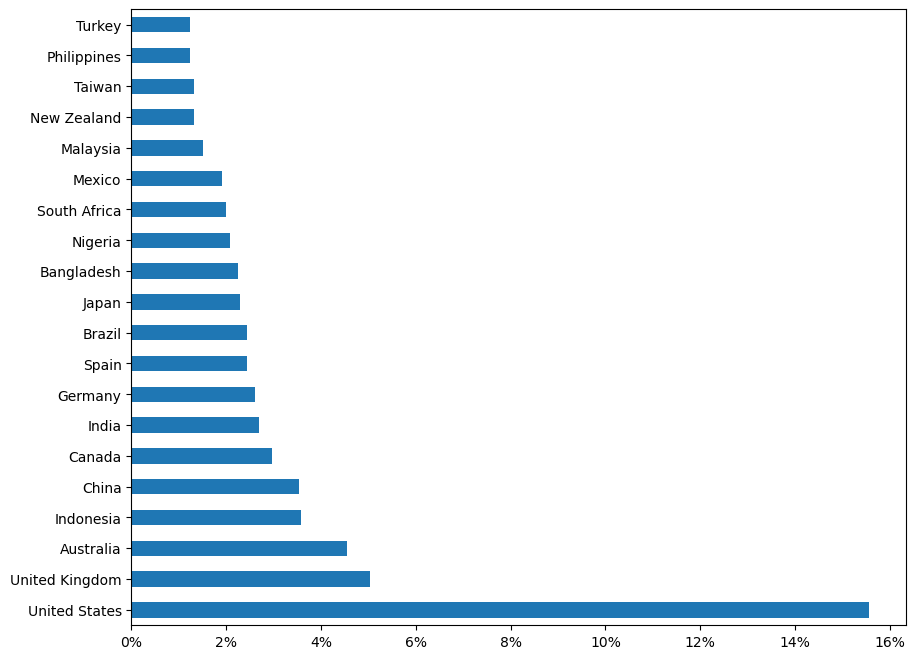

In [87]:
ax = (npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False, normalize=True)*100).head(20).plot.barh(figsize=(10,8))
plt.savefig('../Figure_GPT2_3/Publications_countries.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))

In [ ]:
#'topic_0': 'Sytem_Learning_Social_Research', 'topic_1': 'Health_Medical_Nursing',
#                          'topic_2': 'Learning_School_Student',
#                          'topic_3': 'Impact_Adaptation_Knowledge_Agriculture',
#                          'topic_4': 'Sustainability_SDG_university',
#                          'topic_5': 'Environmental_Concern_Behaviour_Child', 
#                          'topic_6': 'Energy_Mitigation_Emissions',
#                          'topic_7': 'Geomorphology_Geography',
#                          'topic_8': 'School_Teacher_Science',
#                          'topic_9': 'Hazard_Disaster_Risk_Resilience'  

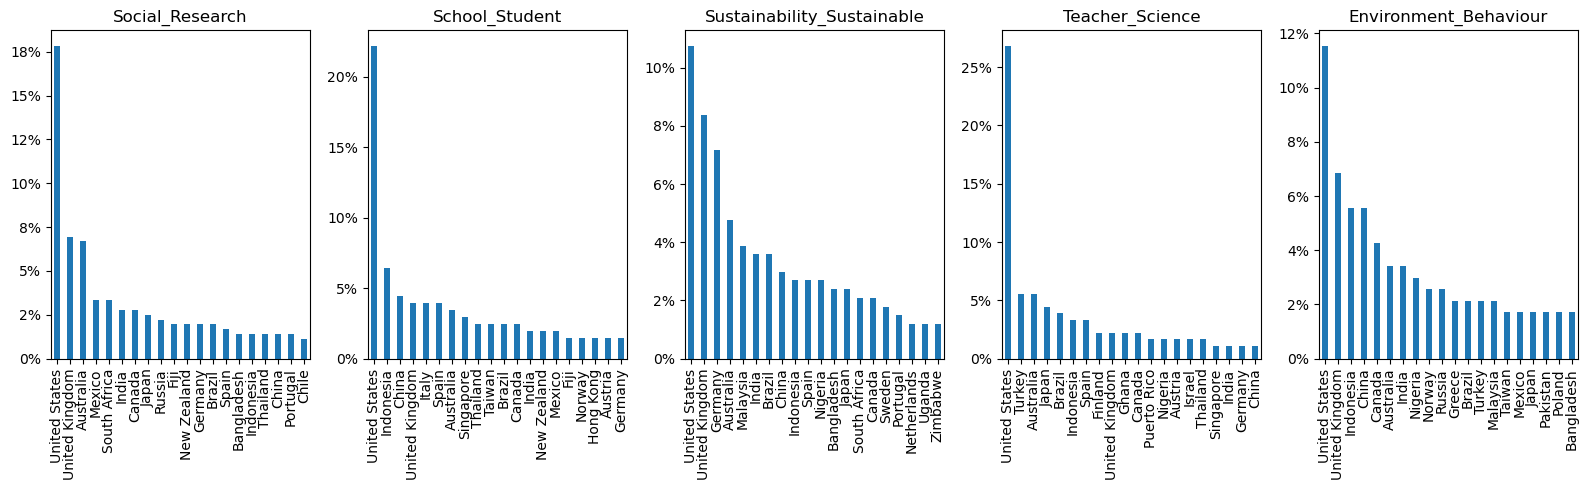

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize =(16,5))
x0=(npr_2006[npr_2006['Topic'] == 0]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20) #autopct='%.2f')
x1=(npr_2006[npr_2006['Topic'] == 2]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20) #autopct='%.2f')
x2=(npr_2006[npr_2006['Topic'] == 4]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20)#autopct='%.2f')
x3=(npr_2006[npr_2006['Topic'] == 8]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20) #autopct='%.2f')
x4=(npr_2006[npr_2006['Topic'] == 5]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20) #autopct='%.2f')
#add DataFrames to subplots
x0.plot.bar(ax=axes[0])
axes[0].set_title("Social_Research")
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
x1.plot.bar(ax=axes[1])
axes[1].set_title("School_Student")
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
x2.plot.bar(ax=axes[2])
axes[2].set_title("Sustainability_Sustainable")
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
x3.plot.bar(ax=axes[3])
axes[3].set_title("Teacher_Science")
axes[3].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
x4.plot.bar(ax=axes[4])
axes[4].set_title("Environment_Behaviour")
axes[4].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
plt.tight_layout()
plt.savefig('../Figure_GPT2_4/Topic_countries_1.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.2,
        facecolor='auto', edgecolor='auto',
        backend=None)

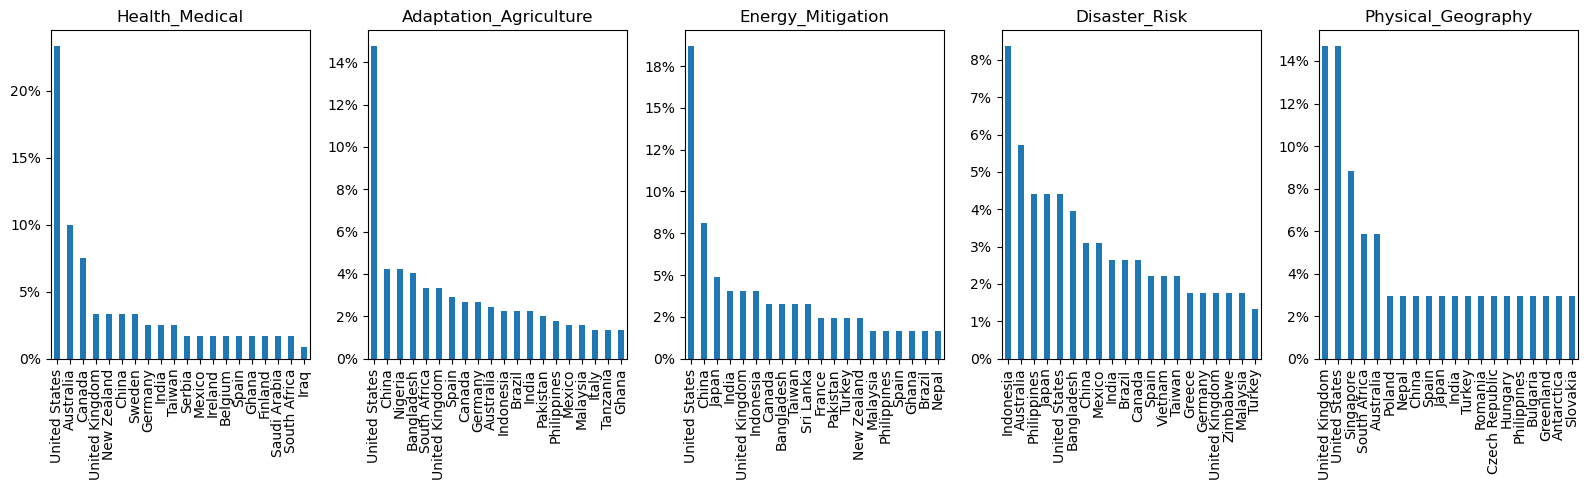

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize =(16,5))
x0=(npr_2006[npr_2006['Topic'] == 1]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20) 
x1=(npr_2006[npr_2006['Topic'] == 3]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20) 
x2=(npr_2006[npr_2006['Topic'] == 6]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20)
x3=(npr_2006[npr_2006['Topic'] == 9]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20) 
x4=(npr_2006[npr_2006['Topic'] == 7]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(normalize = True)*100).head(20)

#add DataFrames to subplots
x0.plot.bar(ax=axes[0], y = x0.index.sort_values())
axes[0].set_title("Health_Medical")
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
x1.plot.bar(ax=axes[1])
axes[1].set_title("Adaptation_Agriculture")
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
x2.plot.bar(ax=axes[2])
axes[2].set_title("Energy_Mitigation")
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
x3.plot.bar(ax=axes[3])
axes[3].set_title("Disaster_Risk")
axes[3].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
x4.plot.bar(ax=axes[4])
axes[4].set_title("Physical_Geography")
axes[4].yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
plt.tight_layout()
plt.savefig('../Figure_GPT2_4/Topic_countries_2.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [ ]:
#fig, ax = plt.subplots(figsize=(20,10))
#ax = sns.countplot(x = npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first").dropna()['countries'],
#              data = npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(), ax=ax)
#ax.bar_label(ax.containers[0], label_type='edge')
#plt.tight_layout()

In [ ]:
#npr_new.drop_duplicates(keep = "first").head(20)

In [ ]:
#npr_new.groupby(['index', 'countries']).first()

In [101]:
df10 = npr_2006['countries'].explode().reset_index()

In [102]:
#for i, row in df10.iterrows():    
code = []
for p in df10.countries:
    try:
        aa = country_name_to_country_alpha3(p)
        code.append(aa)
    except:
        code.append('')
df10['code'] = code

In [ ]:
#npr_2006.drop('Country_0', axis = 1, inplace = True)

In [ ]:
#npr_2006['continent'].value_counts(ascending=False).head(20).plot.barh(figsize=(10,8)) #autopct='%.2f')

In [ ]:
#npr_2006['continent'].value_counts(ascending=False)

In [103]:
npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).head(20)

United States     352
United Kingdom    114
Australia         103
Indonesia          81
China              80
Canada             67
India              61
Germany            59
Spain              55
Brazil             55
Japan              52
Bangladesh         51
Nigeria            47
South Africa       45
Mexico             43
Malaysia           34
New Zealand        30
Taiwan             30
Philippines        28
Turkey             28
Name: countries, dtype: int64

In [104]:
npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).sum()

2261

In [105]:
npr_2006['countries'].shape

(5705,)

In [106]:
#Proportion of papers mentioning specific countries
(2261/5705)*100

39.6319018404908

In [107]:
df8 = npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).rename_axis('countries').to_frame('counts')


In [108]:
npr_2006['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries']

0                 NaN
1       United States
2               Italy
3           Australia
5                 NaN
            ...      
7251              NaN
7252              NaN
7253              NaN
7254              NaN
7255              NaN
Name: countries, Length: 6281, dtype: object

In [109]:
df8.reset_index(inplace=True)

In [110]:
df8['countries'].iloc[100:157]

100                 Botswana
101                   Cyprus
102               Mozambique
103                   Zambia
104                   Kosovo
105                     Mali
106                  Namibia
107             Burkina Faso
108               Cape Verde
109                   Guinea
110              Afghanistan
111                    Tonga
112                Mauritius
113                  Comoros
114              North Korea
115                  Grenada
116                   Guyana
117                  Tunisia
118       Dominican Republic
119                   Bhutan
120               Madagascar
121                  Uruguay
122                  Somalia
123            Guinea-Bissau
124                  Mayotte
125                  Belarus
126                    Qatar
127                   Rwanda
128    Palestinian Territory
129                 Suriname
130               Guadeloupe
131                    Syria
132                Venezuela
133            French Guiana
134           

In [111]:
#for i, row in df10.iterrows():    
code = []
continents = []
for p in df8.countries:
    try:
        aa = country_name_to_country_alpha3(p)
        b1 = country_name_to_country_alpha2(p)
        bb = country_alpha2_to_continent_code(b1)
        code.append(aa)
        continents.append(bb) 
    except:
        code.append('')
        continents.append('')
df8['code'] = code
df8['continents'] = continents

In [112]:
df8['code'].iloc[51] = 'ATA'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/3450539037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['code'].iloc[51] = 'ATA'


In [113]:
df8['continents'].iloc[51] = 'AQ'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/2354726059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['continents'].iloc[51] = 'AQ'


In [114]:
df8['code'].iloc[128] = 'PSE'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/1077518237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['code'].iloc[128] = 'PSE'


In [115]:
df8['continents'].iloc[128] = 'AS'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/2772186268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['continents'].iloc[128] = 'AS'


In [116]:
df8['code'].iloc[104] = 'XK'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/1683465072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['code'].iloc[104] = 'XK'


In [117]:
df8['continents'].iloc[104] = 'EU'

/var/folders/hd/n13870fj1mv_x9bv1cytjvk80000gn/T/ipykernel_39431/427206530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['continents'].iloc[104] = 'EU'


In [118]:
df8.iloc[0:50,:]

,countries,counts,code,continents
0,United States,352,USA,NA
1,United Kingdom,114,GBR,EU
2,Australia,103,AUS,OC
3,Indonesia,81,IDN,AS
4,China,80,CHN,AS
5,Canada,67,CAN,NA
6,India,61,IND,AS
7,Germany,59,DEU,EU
8,Spain,55,ESP,EU
9,Brazil,55,BRA,SA


In [131]:
import plotly.express as px
import plotly.graph_objects as go
import kaleido

fig = go.Figure(data=go.Choropleth(
    locations = df8['code'],
    z = df8['counts'],
    text = df8['countries'],
    colorscale = 'sunsetdark',
    autocolorscale=False,
    reversescale=False,
    #marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Country count', 
))
fig.update_geos(projection_type="natural earth", showcountries = True,showlakes = False,
                showocean=True, oceancolor="LightBlue")

fig.update_layout(title_text = 'Geographical distributions of case studies')
                                                                                                               
fig.show()

fig.write_image("../Figure_GPT2_4/Map_2.png")

#plt.savefig('../Figure_GPT2_2/Map_2.png', dpi=400)

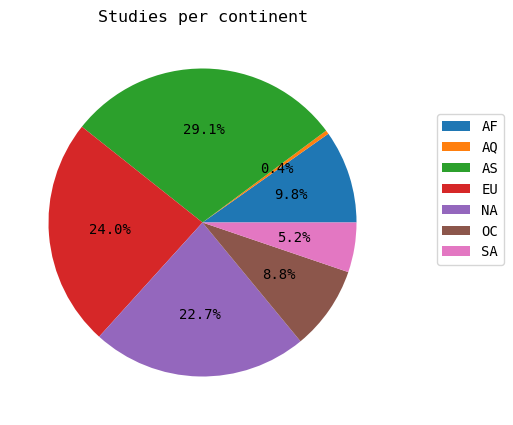

In [132]:
aa = df8.groupby(df8['continents']).sum()
ax = aa.plot.pie(subplots=True,figsize=(5,5),legend=True,autopct='%1.1f%%', labeldistance = None)
plt.ylabel(None)
plt.title('Studies per continent')
plt.legend(bbox_to_anchor=(1.3, 0.8), fontsize = 10)
figure_name = 'Pie_Chart_Continents'
plt.savefig('../Figure_GPT2_4/Pie_continents.png', dpi='figure',
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
plt.show()

In [121]:
df12 = df8.groupby(df8['continents']).sum()

In [122]:
df12.reset_index(inplace=True)

In [123]:
full_name = ['Africa', 'Antarctica', 'Asia', 'Europe', 'N. America', 'S. America', 'Oceania'] 
df12['Continent_Full_Name'] = full_name

In [124]:
df12

,continents,counts,Continent_Full_Name
0,AF,221,Africa
1,AQ,9,Antarctica
2,AS,659,Asia
3,EU,542,Europe
4,NA,513,N. America
5,OC,199,S. America
6,SA,118,Oceania


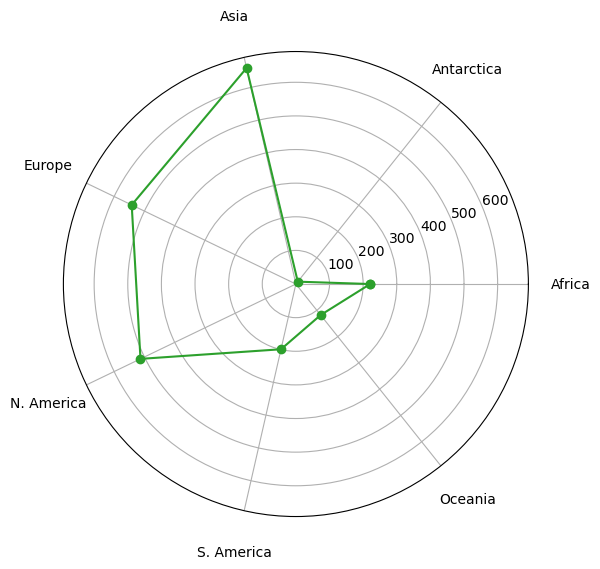

In [125]:
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111, projection="polar")

# theta has 7 different angles, and the first one repeated
theta = np.arange(len(df12) + 1) / float(len(df12)) * 2 * np.pi
# values has the 7 values from 'counts', with the first element repeated
values = df12['counts'].values
values = np.append(values, values[0])

# draw the polygon and the mark the points for each angle/value combination
l1, = ax.plot(theta, values, color="C2", marker="o", label="counts")
plt.xticks(theta[:-1], df12['Continent_Full_Name'], color='black', size=10)
ax.tick_params(pad=20,labelrotation =0) # to increase the distance of the labels to the plot
# fill the area of the polygon with green and some transparency
#ax.fill(theta, values, 'blue', alpha=0.1)

#plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
#plt.title("Title")
plt.show()

In [ ]:
df10 = npr_2006[npr_2006['Topic'] == 1]['countries'].explode().reset_index().drop_duplicates(keep = "first")['countries'].value_counts(ascending=False).rename_axis('countries').to_frame('counts')


In [386]:
from collections import Counter
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [383]:
topic_results.shape

(5705, 10)

In [387]:
nmf_keys = get_keys(topic_results)
nmf_categories, nmf_counts = keys_to_counts(nmf_keys)

In [388]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [403]:
len(nmf_keys)

5705

In [393]:
n_topics = 10

In [394]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii','ignore').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [440]:
top_n_words_nmf = get_top_n_words(10, nmf_keys, dtm,tfidf)

for i in range(len(top_n_words_nmf)):
    print("Topic {}: ".format(i+1), top_n_words_nmf[i])

Topic 1:  research social challenge learning approach community new world problem project
Topic 2:  health medical nursing public nurse environmental professional care impact human
Topic 3:  student use school study course learning learn science research knowledge
Topic 4:  adaptation farmer perception knowledge study information level impact public use
Topic 5:  sustainability sustainable development university research esd environmental paper approach student
Topic 6:  environmental behaviour environment student issue child study human problem nature
Topic 7:  energy renewable technology emission use fuel student sustainable fossil solar
Topic 8:  geography physical entry dictionary soil discipline cover biogeography ocean hydrology
Topic 9:  science teacher scientific student school study research use knowledge issue
Topic 10:  disaster risk community flood reduction hazard resilience natural school management


In [399]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [405]:
tsne_lsa_vectors_2 = tsne_lsa_model.fit_transform(topic_results)

/Users/vmuccion/opt/anaconda3/envs/ClimateEducation/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5705 samples in 0.004s...
[t-SNE] Computed neighbors for 5705 samples in 0.752s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5705
[t-SNE] Computed conditional probabilities for sample 2000 / 5705
[t-SNE] Computed conditional probabilities for sample 3000 / 5705
[t-SNE] Computed conditional probabilities for sample 4000 / 5705
[t-SNE] Computed conditional probabilities for sample 5000 / 5705
[t-SNE] Computed conditional probabilities for sample 5705 / 5705
[t-SNE] Mean sigma: 0.013802
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.133896
[t-SNE] KL divergence after 2000 iterations: 1.315570


In [406]:
nmf_mean_topic_vectors = get_mean_topic_vectors(nmf_keys, tsne_lsa_vectors_2)

In [415]:
tsne_lsa_vectors[:]

,x,y,hue
0,-27.477764,13.183151,5
1,-15.908205,14.310265,5
2,-44.442902,-12.528591,3
3,19.968874,-15.076223,2
4,-2.042523,7.874936,0
...,...,...,...
5700,-16.125092,2.932705,0
5701,-5.697186,-29.808315,0
5702,52.598083,10.886884,1
5703,28.495354,3.717627,2


In [422]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook


In [418]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [445]:
plot = figure(title="t-SNE Clustering of {} NMF Topics".format(n_topics), width=1000, height=1000)
plot.scatter(x=tsne_lsa_vectors_2[:,0], y=tsne_lsa_vectors_2[:,1], color=colormap[nmf_keys])

for t in range(n_topics):
    label = Label(x=nmf_mean_topic_vectors[t][0], y=nmf_mean_topic_vectors[t][1], 
                  text=top_n_words_nmf[t], text_color='black', text_align='center', x_offset=0, y_offset=-8)
    plot.add_layout(label)

show(plot)
#colormap[t]